# Not yet finished. Generative Adveserial Network

### What is a Generative Model ?

Given a set of data instances X and a set of labels Y:
+ Generative model captures the joint probability p(X,Y)(ergo p(X) if there are no labels).
+ Discriminative models capture the conditional probability p(Y|X).


![alt text](https://developers.google.com/machine-learning/gan/images/generative_v_discriminative.png "1")



In [1]:
# https://colab.research.google.com/github/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb?utm_source=ss-gan&utm_campaign=colab-external&utm_medium=referral&utm_content=tfgan-intro
    
# https://github.com/tensorflow/gan/tree/master/tensorflow_gan/examples    

# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9



In [2]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
print("Using data [%s]" % (name))


# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

Using data [Only 4 moments]


In [3]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))
    
    
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]





def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

Epoch 0: D (0.5744878053665161 real_err, 0.8298530578613281 fake_err) G (0.5748206973075867 err); Real Dist ([4.0573997382968665, 1.2367600157066743]),  Fake Dist ([-0.29472562140226366, 0.010301706667606873]) 
Plotting the generated distribution...
 Values: [-0.3053029477596283, -0.28387123346328735, -0.2860601842403412, -0.28260695934295654, -0.30078989267349243, -0.27903974056243896, -0.28962191939353943, -0.281319797039032, -0.2961729168891907, -0.2954379916191101, -0.2978188991546631, -0.31052184104919434, -0.30307823419570923, -0.2807721793651581, -0.2872793972492218, -0.28559446334838867, -0.3054419755935669, -0.29373466968536377, -0.29493457078933716, -0.2963580787181854, -0.2955780625343323, -0.29668310284614563, -0.2779833972454071, -0.2998453378677368, -0.3058618903160095, -0.3113091289997101, -0.2820777893066406, -0.30939096212387085, -0.31326302886009216, -0.30509623885154724, -0.2807215452194214, -0.29077720642089844, -0.2911069691181183, -0.28895869851112366, -0.30975782

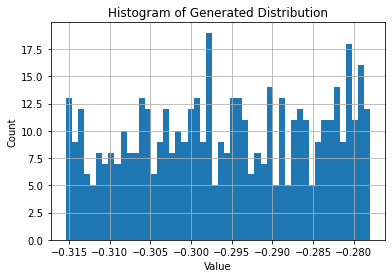

In [4]:


def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 1#5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    
    # Generator.
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    # Disc.
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones(d_real_decision.shape)))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params
            
            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(d_fake_decision.shape)))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    print("Plotting the generated distribution...")
    values = extract(g_fake_data)
    print(" Values: %s" % (str(values)))
    plt.hist(values, bins=50)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Histogram of Generated Distribution')
    plt.grid(True)
    plt.show()
    

train()

# Generative Adversarial Networks - Mode Dropping

One well known problem with GANs is mode dropping - that is when a GAN learns to sample from one part of the target distribution very well, but does not produce samples from other high probability areas. [Unrolled Generative Adversarial Networks](https://openreview.net/pdf?id=BydrOIcle) from ICLR 2017 has a nice easy to grasp visualisation of this, which I reproduce here.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns; sns.set(style="white", color_codes=True)
%matplotlib inline

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.l1_size = 300
        self.l2_size = 300
        self.l3_size = 150
        self.relu = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, self.l3_size)
        self.l4 = torch.nn.Linear(self.l3_size, out_features)
        
    def forward(self,z):
        
        a1 = self.relu(self.l1(z))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        a4 = self.l4(a3)
        return a4
    
    
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1_size = 300
        self.l2_size = 300
        self.l3_size = 150
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, self.l3_size)
        self.l4 = torch.nn.Linear(self.l3_size, out_features)
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        a4 = self.l4(a3)
        return a4
    
    def forward_with_sigmoid(self, x):
        return self.sigmoid(self.forward(x))

In [7]:

x1 = np.random.multivariate_normal(np.array([0,8]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x2 = np.random.multivariate_normal(np.array([0,-8]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x3 = np.random.multivariate_normal(np.array([-8,0]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x4 = np.random.multivariate_normal(np.array([8,0]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x5 = np.random.multivariate_normal(np.array([4,4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x6 = np.random.multivariate_normal(np.array([-4,-4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x7 = np.random.multivariate_normal(np.array([-4,4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x8 = np.random.multivariate_normal(np.array([4,-4]), np.array([[0.25, 0], [0, 0.25]]), size=200)

x_real = np.concatenate([x1, x2, x3, x4, x5, x6, x7, x8], axis=0)

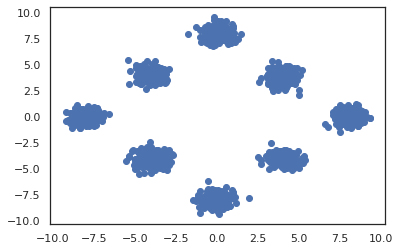

In [8]:
plt.scatter(x_real[:, 0], x_real[:,1])

  0%|          | 0/30000 [00:00<?, ?it/s]

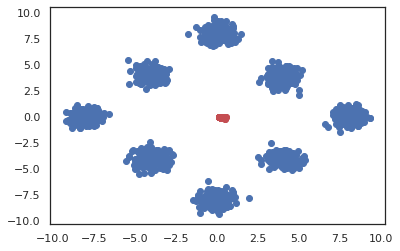

 10%|▉         | 2997/30000 [01:25<13:07, 34.27it/s]

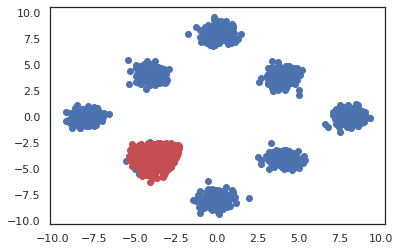

 20%|█▉        | 5997/30000 [03:02<11:05, 36.09it/s]

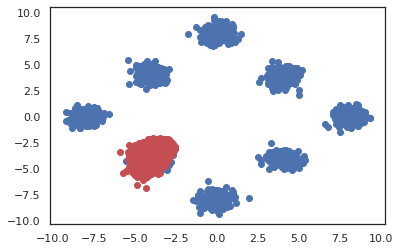

 30%|██▉       | 8997/30000 [05:01<11:42, 29.91it/s]  

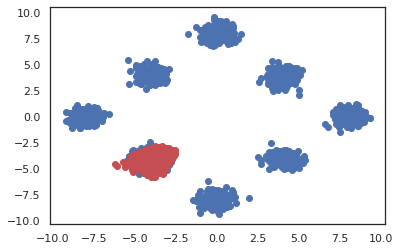

 40%|███▉      | 11998/30000 [06:31<10:27, 28.69it/s]

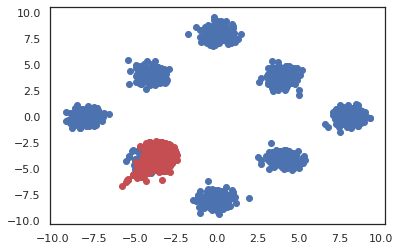

 50%|████▉     | 14998/30000 [08:18<08:58, 27.87it/s]

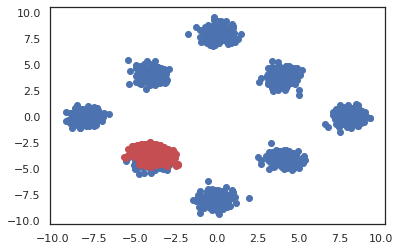

 60%|█████▉    | 17998/30000 [10:14<07:21, 27.18it/s]

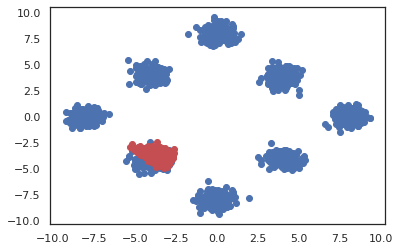

 70%|██████▉   | 20999/30000 [12:09<06:13, 24.08it/s]

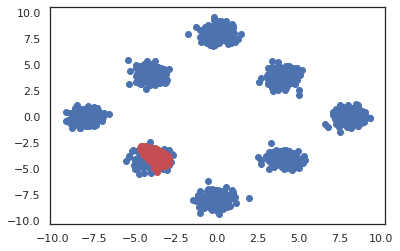

 80%|███████▉  | 23999/30000 [14:23<04:38, 21.56it/s]

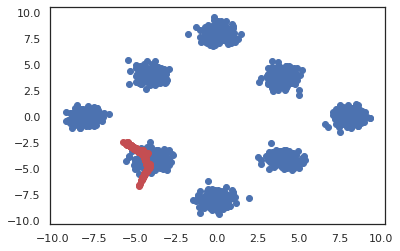

 90%|█████████ | 27000/30000 [16:34<02:27, 20.32it/s]

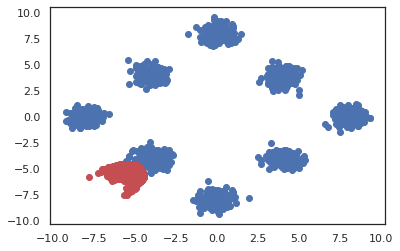

100%|██████████| 30000/30000 [18:57<00:00, 26.37it/s]


In [9]:
G = Generator(2,2)
D = Discriminator(2,1)
G_opt = torch.optim.Adam(G.parameters(), lr=0.001)
D_opt = torch.optim.Adam(D.parameters(), lr=0.001)

x_t_real = torch.from_numpy(x_real).float()

for t in tqdm(range(30000)):
    for i in range(5):
        ind = np.arange(x_real.shape[0])
        mask = np.random.choice(ind, 50)
        x_real_batch = torch.from_numpy(x_real[mask]).float()

        z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
        x_fake = G.forward(z)
        X = torch.cat([x_fake, x_real_batch])
        
        y_hat = D.forward(X)
        
        y = torch.from_numpy(
            np.concatenate([np.zeros((x_real_batch.shape[0],1)), np.ones((x_real_batch.shape[0],1))])).float()
        
        G_opt.zero_grad()
        D_opt.zero_grad()
        Dloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        Dloss.backward()
        D_opt.step()
    
    
    z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
    x_fake = G.forward(z)
    y_hat = D.forward(x_fake)
    
    D_opt.zero_grad()
    G_opt.zero_grad()
    Gloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, torch.ones_like(y_hat))
    Gloss.backward()
    G_opt.step()
    
    if t%3000==0:
        z = torch.from_numpy(np.random.normal(size=x_real.shape)).float()
        x_fake = G.forward(z).data.numpy()
        plt.scatter(x_real[:, 0], x_real[:,1])
        plt.scatter(x_fake[:,0], x_fake[:,1], c='r')
        plt.show()

In [10]:
z = torch.from_numpy(np.random.normal(size=(2000,2))).float()
x_fake = G.forward(z).data.numpy()

In [11]:
x_fake[:5]

array([[-4.6230907, -3.4341319],
       [-3.52904  , -5.168458 ],
       [-3.7803235, -4.0884395],
       [-3.9265804, -3.7275734],
       [-3.3262253, -4.5226502]], dtype=float32)

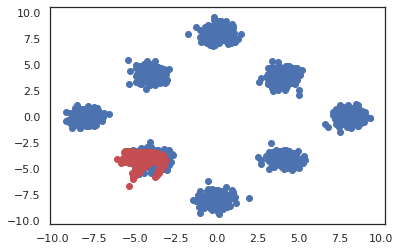

In [12]:
plt.scatter(x_real[:, 0], x_real[:,1])
plt.scatter(x_fake[:,0], x_fake[:,1], c='r')

/home/demir/anaconda3/envs/pDL/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


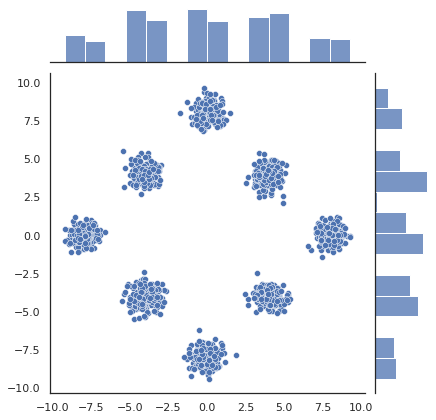

In [13]:
sns.jointplot(x_real[:,0], x_real[:,1])

/home/demir/anaconda3/envs/pDL/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


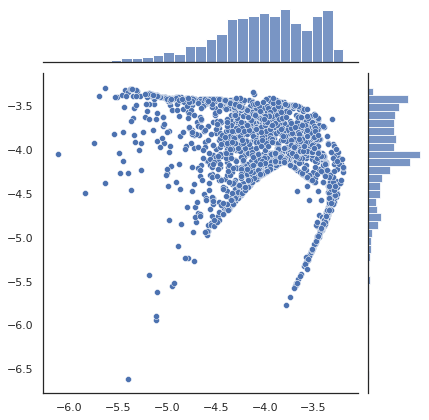

In [14]:
sns.jointplot(x_fake[:,0], x_fake[:,1])

In [15]:
from tqdm import tqdm
import seaborn as sns; sns.set(style="white", color_codes=True)

In [16]:
class Generator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.l1_size = 100
        self.l2_size = 100
        self.relu = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, out_features)
        
    def forward(self,z):
        
        a1 = self.relu(self.l1(z))
        a2 = self.relu(self.l2(a1))
        a3 = self.l3(a2)
        return a3
    
    
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1_size = 100
        self.l2_size = 100
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, out_features)
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.l3(a2)
        return a3
    
    def forward_with_sigmoid(self, x):
        return self.sigmoid(self.forward(x))

In [17]:
cov = 0.2*np.eye(2)+0.8
x_real = np.random.multivariate_normal(np.ones(2)*5, cov, size=2000)

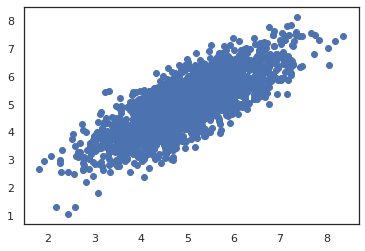

In [18]:
plt.scatter(x_real[:, 0], x_real[:,1])

In [19]:
G = Generator(2,2)
D = Discriminator(2,1)
G_opt = torch.optim.Adam(G.parameters(), lr=0.001)
D_opt = torch.optim.Adam(D.parameters(), lr=0.001)

x_t_real = torch.from_numpy(x_real).float()
#y = torch.from_numpy(np.concatenate([np.zeros(2000), np.ones(2000)])).float().reshape(-1,1)
for i in tqdm(range(8000)):
    for i in range(5):
        ind = np.arange(x_real.shape[0])
        mask = np.random.choice(ind, 50)
        x_real_batch = torch.from_numpy(x_real[mask]).float()

        z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
        x_fake = G.forward(z)
        X = torch.cat([x_fake, x_real_batch])
        y_hat = D.forward(X)
        y = torch.from_numpy(
            np.concatenate([np.zeros((x_real_batch.shape[0],1)), np.ones((x_real_batch.shape[0],1))])).float()
        
        G_opt.zero_grad()
        D_opt.zero_grad()
        Dloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        Dloss.backward()
        D_opt.step()
    
    
    z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
    x_fake = G.forward(z)
    y_hat = D.forward(x_fake)
    
    D_opt.zero_grad()
    G_opt.zero_grad()
    Gloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, torch.ones_like(y_hat))
    Gloss.backward()
    G_opt.step()

100%|██████████| 8000/8000 [01:19<00:00, 100.16it/s]


In [20]:
z = torch.from_numpy(np.random.normal(size=(2000,2))).float()
x_fake = G.forward(z).data.numpy()

In [21]:
x_fake[:5]

array([[4.538538 , 5.1856637],
       [4.758734 , 5.870295 ],
       [6.1571965, 5.6960464],
       [6.2448874, 6.4375434],
       [5.386907 , 5.813225 ]], dtype=float32)

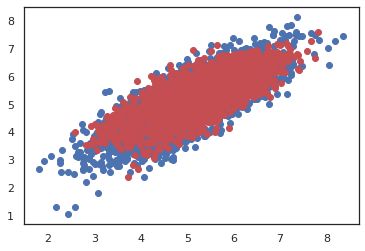

In [22]:
plt.scatter(x_real[:, 0], x_real[:,1])
plt.scatter(x_fake[:,0], x_fake[:,1], c='r')

/home/demir/anaconda3/envs/pDL/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


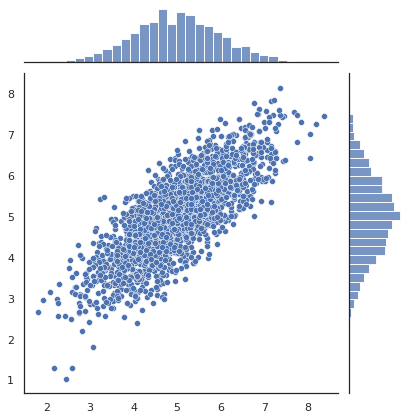

In [23]:
sns.jointplot(x_real[:,0], x_real[:,1])

/home/demir/anaconda3/envs/pDL/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


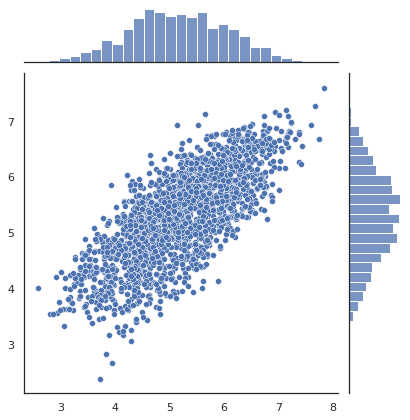

In [24]:
sns.jointplot(x_fake[:,0], x_fake[:,1])